# **Import and variables**

In [67]:
import pandas as pd
import numpy as np
import math
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud, STOPWORDS
# from pandas.compat import lmap, map, u
import matplotlib.pyplot as plt
import pathlib
import requests
import re
import psutil
%reload_ext pycodestyle_magic
%pycodestyle_on
# %pycodestyle_off

# Local drive location of the dataframe
MAIN_FOLDER = 'c:/Users/champ/Python_proj/'
MWML_FOLDER = 'made_with_ml_repo/temp/moviebuddy/meta_data/'
CLEANED_FILE = "filtered.csv"
tfidf_np_matrix = ''

# Load from 'local' OR from 'gdrive'
drive = 'local'
# drive = 'gdrive'

if drive == 'gdrive':
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

# **Function definitions**

In [66]:
def prep_db(file, file_type):
    '''
    This module reads and prepares the db : cleans,
    deletes the columns with 'Unnamed' values,
    fills NaN values
    input :
    file # the movieset file
    file type # csv file type
    output :
    df # read movie set dataframe
    '''
    if file_type == 'csv':
        df = pd.read_csv(file, sep=';', dtype=str)  # Read CSV File
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.fillna('')  # clean the data - get rid of NaN
    df = df.astype(str)  # change the default data type to string
    return(df)


def combine_row_text(features, df):
    '''
    This module combines text columns and sets
    the case of the combined text to lower
    args :
    input :
    features # list of database columns to search in the movies database
    df # pandas dataframe
    output : counts # dataframe
    '''
    df['comb'] = ''
    for feature in features:
        df['comb'] = df['comb'].str.cat(df[feature].copy(), sep=',')
    df['comb'] = df['comb'].str.lower()
    return(df)


def highest_count_words(df):
    '''
    This module takes as input the imported movie dataset
    and counts the occurance of the words and
    sets the columns in decreasing order
    args :
    input : df # pandas dataframe of the imported movie dataset
    output : counts # dataframe of the counted words
    '''
    count_matrix = vectorizer.fit_transform(df.keywords)
    count_matrix = count_matrix.astype(np.int32)
    counts = pd.DataFrame(count_matrix.toarray(),
                          index=df.title,
                          columns=vectorizer.get_feature_names())
    return(counts)


def find_delete_columns(counts, character, char):
    '''
    This module is run off of the delete columns mega
    and deletes the unwanted columns of words
    args :
    input :
    counts # dataframe of column of counted words
    character # regex code for the particular character(s)
    char # the unwanted character(s) that I want deleted
    output :
    counts # dataframe without the unwanted characters
    '''
    t = 0  # column counter
    n = 1
    orig = len(counts.columns)
    print(f'removing {char} .... ')
    for i in counts.columns:
        if t == (n * 1000):
            # print(str(round(t/len(counts.columns)*100,0))+'%')
            n += 1
        t += 1
        if re.findall(character, i):
            del counts[i]
    return(counts)


def most_frequent_words(counts):
    '''
    This module prepares the most frequent words of the
    specific movie's selection types and ouputs to a csv
    input :
    counts # dataframe of column of counted words
    output :
    counts_transposed # column transferred to rows
    and saved to a csv
    '''
    counts_transposed = counts.T
    counts_transposed['sum'] = counts_transposed.sum(axis=1)
    cols = counts_transposed.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    counts_transposed = counts_transposed.astype(np.int32)
    counts_transposed = counts_transposed[cols]
    counts_transposed = counts_transposed.sort_values(by=['sum'],
                                                      axis=0, ascending=False)
    movie_counts = counts_transposed
    most_frequent_words = counts_transposed[['sum']]
    most_frequent_words = most_frequent_words.reset_index()
    most_frequent_words = most_frequent_words.rename(columns={'index': 'word',
                                                              'sum':'frequency'}, index={'title': 'index'})
    return(most_frequent_words,counts_transposed)


def cloud_word(word, nr_of_movies, movie_counts):
    var = word
    df = movie_counts.T[[var]]
    return(df.sort_values(var, ascending=False).head(nr_of_movies))


def make_pandas(freq_words, nr_of_movies, movie_counts):
    '''
    construct pandas from frequently used words,
    crossed with number of movies, per keyword row count
    args :
    input :
    freq_words # frequently used words
    nr_of_movies # max number of recommendations
    movie_counts # keyword row count
    output :
    df # movie recommendations
    '''
    word_list = freq_words['word']
    word_list = word_list.tolist()
    t = 0
    for i in word_list:
        movies = cloud_word(i, nr_of_movies, movie_counts)
        movies = movies[1:]
        movies = movies.reset_index()
        movies = pd.DataFrame(data=movies)
        movies = movies.rename(columns={'title':i})
        movies = movies.iloc[:, :-1]
        if t == 0:
            df1 = movies
        elif t> 1:
            df1 = pd.concat([df1,movies], axis=1)
        t+=1
    return(df1)


def word_cloud(wrds):
    '''
    The function is the word cloud generator
    Input : colunms of title and keywords of words and
    groups of words from the db.
    Output : the word cloud graphic
    '''
    print(wrds)
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width=500, height=500,
                          background_color='white',
                          stopwords=stopwords,
                          random_state=None,
                          min_font_size=15).generate(','.join(wrds))
    #  plot the WordCloud image
    plt.figure(figsize=(10, 10), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig(MAIN_FOLDER + MWML_FOLDER + 'word_cloud_graphic.png')
    plt.tight_layout(pad=0)
    plt.show()

    
def prep_db(file, file_type):
    '''
    This module reads and prepares the db : cleans,
    deletes the columns with 'Unnamed' values,
    fills NaN values
    input :
    file # the movieset file
    file type # csv file type
    output :
    df # read movie set dataframe
    '''
    if file_type == 'csv':
        df = pd.read_csv(file, sep=';', dtype=str)  # Read CSV File
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.fillna('')  # clean the data - get rid of NaN
    df = df.astype(str)  # change the default data type to string
    return(df)


def display_all(df):
    '''
    This function displays all possible columns of the movie database
    '''
    with pd.option_context("display.max_rows", 1000,
                           "display.max_columns", 1000):
        return(df)


def recommendations(titles, tfidf_np_matrix=None):
    '''
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    '''
    idx = []
    recommended_movies = []

    for title in titles:
        idx.append(indices[indices == title].index[0])
    print(idx)
    user_pref_vector = tfidf_np_matrix[idx].mean(axis=0)
    print(user_pref_vector)
    cosine_sim = cosine_similarity(tfidf_matrix,
                                   np.atleast_2d(user_pref_vector))
    df_cosine_sim = pd.DataFrame(cosine_sim, columns=['sim_score'])
    df_cosine_sim = df_cosine_sim.sort_values(by='sim_score', ascending=False)
    print(df_cosine_sim.head(20))
    top_10_indexes = list(df_cosine_sim.iloc[0:(10+len(titles))].index)
    print(top_10_indexes)
    for n, i in enumerate(top_10_indexes):
        if n < len(titles):
            continue
        recommended_movies.append([movies_subset.title.iloc[i], movies_subset.genres.iloc[i], movies_subset.keywords.iloc[i],
                                   movies_subset.popularity.iloc[i],
                                   movies_subset.average_vote.iloc[i],
                                   movies_subset.num_votes.iloc[i],
                                   df_cosine_sim.sim_score.iloc[n]])

    return pd.DataFrame(recommended_movies, columns=['movie_title',
                                                     'genres',
                                                     'keywords',
                                                     'popularity',
                                                     'average_vote',
                                                     'num_votes',
                                                     'cosine_score'])

ValueError: too many values to unpack (expected 3)

ValueError: too many values to unpack (expected 3)

ValueError: too many values to unpack (expected 3)

ValueError: too many values to unpack (expected 3)

ValueError: too many values to unpack (expected 3)

# **Exploratory data analysis**

## --- Read the "movie" data set 

In [39]:
df = pd.read_csv(MAIN_FOLDER + MWML_FOLDER + CLEANED_FILE, sep=';',
                 dtype=str)  # Read CSV File
nr_movies = len(df)
print(f'There are {nr_movies} in the database')
print('')
df.head()

There are 45416 in the database



,id,title,tagline,description,genres,keywords,date,collection,runtime,revenue,...,director,cast,production_companies,production_countries,popularity,average_vote,num_votes,language,imdb_id,poster_url
0,460135,LEGO DC Super Hero Girls: Brain Drain,NaN,"When Supergirl, Wonder Woman, Batgirl, Bumbleb...",animation,"superhero, lego",2017-08-30,DC Super Hero Girls Collection,0.0,0.0,...,Todd Grimes,"Grey Griffin, Tara Strong, Anais Fairweather, ...",Warner Bros. Animation,United States of America,8.413734,10.0,2.0,en,tt7158814,/niLX2txdI5GlVowJlnb5Hr26QpK.jpg
1,464207,The Truth Is in the Stars,NaN,"William Shatner sits down with scientists, inn...",documentary,"nature, science, canadian movie",2017-05-01,NaN,86.0,0.0,...,Craig Thompson,"William Shatner, Neil deGrasse Tyson, Chris Ha...",NaN,Canada,1.075249,7.5,2.0,en,tt7104950,/tqEtNlOmEAJKrJGGrkGMyLjfRrq.jpg
2,463800,Firebase,NaN,"Set during the Vietnam war, Firebase follows A...","action, science fiction, war","vietnam war, short",2017-06-28,NaN,27.0,0.0,...,Neill Blomkamp,"Steve Boyle, Nic Rhind, Robert Hobbs, Chris Wi...",Oats Studio,Canada,2.129137,7.3,28.0,en,tt7078926,/e6qVOjp3QKHrA7k2sAbJSlDXkRM.jpg
3,464111,Zygote,NaN,"Stranded in an Arctic mine, two survivors are ...","horror, science fiction",NaN,2017-07-12,NaN,23.0,0.0,...,Neill Blomkamp,"Dakota Fanning, Jose Pablo Cantillo",Oats Studio,Canada,3.214001,7.2,28.0,en,tt7078780,/rjm7KaiLsEwRcxnlsaX9ryzzK1B.jpg
4,462108,Chris D'Elia: Man on Fire,NaN,Unbridled comic Chris D'Elia reconsiders his a...,comedy,stand-up comedy,2017-06-27,NaN,65.0,0.0,...,Bill D'Elia,Chris D'Elia,NaN,United States of America,0.482896,5.8,6.0,en,tt7068896,/dZgs1Ym7fe3fPxbeT5hq9XKLaDW.jpg


## --- Availible feature columns

In [40]:
print(df.columns)
print(display(df.tail()))

Index(['id', 'title', 'tagline', 'description', 'genres', 'keywords', 'date',
       'collection', 'runtime', 'revenue', 'budget', 'director', 'cast',
       'production_companies', 'production_countries', 'popularity',
       'average_vote', 'num_votes', 'language', 'imdb_id', 'poster_url'],
      dtype='object')


,id,title,tagline,description,genres,keywords,date,collection,runtime,revenue,...,director,cast,production_companies,production_countries,popularity,average_vote,num_votes,language,imdb_id,poster_url
45411,105158,Edison Kinetoscopic Record of a Sneeze,NaN,A man (Thomas Edison's assistant) takes a pinc...,documentary,NaN,1894-01-09,NaN,1.0,0.0,...,William K.L. Dickson,Fred Ott,Edison Manufacturing Company,United States of America,0.312246,4.7,12.0,en,tt0000008,/utsYe7NaVdiUhXpBwgln3LTucYs.jpg
45412,16624,Blacksmith Scene,NaN,Three men hammer on an anvil and pass a bottle...,drama,"blacksmith, beer, workmen",1893-05-08,NaN,1.0,0.0,...,William K.L. Dickson,"Charles Kayser, John Ott",Edison Manufacturing Company,United States of America,1.061591,5.8,19.0,xx,tt0000005,/6nh4gdZ4cWQbnXDicWIGsOZiZsx.jpg
45413,88013,Poor Pierrot,NaN,"One night, Arlequin come to see his lover Colo...","comedy, animation",short,1892-10-28,NaN,4.0,0.0,...,Émile Reynaud,NaN,NaN,France,0.673164,6.1,19.0,fr,tt0000003,/yCJr2zZqEbWLggyqumVcXBFQABf.jpg
45414,16612,Carmencita,NaN,The first woman to appear in front of an Ediso...,documentary,"dancer, silent film",1894-03-14,NaN,1.0,0.0,...,William K.L. Dickson,Carmencita,Edison Manufacturing Company,United States of America,1.273072,4.9,18.0,en,tt0000001,/6QJowxF4f2hrUtmrDXOqbRDMdDH.jpg
45415,47116,The Winner,NaN,Tou former boxers meet in the ring again after...,"drama, romance, foreign",NaN,1979-03-09,NaN,78.0,0.0,...,Dušan Trančík,"Jaroslav Tomsa, jaroslav pucher, Dagmar Kováči...",NaN,NaN,0.0,0.0,0.0,en,NaN,/yMCadbpPKxmYdkLdVpvsH0tPIwq.jpg


None


## -- Duplicate and missing values rows

### ----- Duplicate full rows

In [43]:
df_duplicates_full_rows = df[df.duplicated()]
df_duplicates_full_rows = df_duplicates_full_rows.sort_values('title',
                                                              ascending=False)
df_duplicates_full_rows_clean = df.drop_duplicates(keep='first')
df2 = df_duplicates_full_rows_clean
df2 = df2.sort_values('title', ascending=False)
df2.to_csv(MAIN_FOLDER + MWML_FOLDER + 'duplicates.csv',
           index=False, header=True, sep=',')
print('')
print(f'There are {len(df_duplicates_full_rows)} instances of duplicate ROWS.')
print('')
print(f'The df has been cleaned and has been reduced by \
      {((1-(len(df_duplicates_full_rows_clean))/len(df))*100):.2f}%')
print('')


There are 0 instances of duplicate ROWS.

The df has been cleaned and has been reduced by       0.00%



### ----- Duplicate imdb_id

In [53]:
duplicate_column = 'imdb_id'  # 'title'
df_duplicates = df2[df2[duplicate_column].duplicated()]

df_duplicate_titles = df_duplicates[[duplicate_column]]

unique = df_duplicate_titles[duplicate_column].unique()

df3 = df2.drop_duplicates(subset=['imdb_id'], keep='first')
df3 = df3.sort_values(duplicate_column, ascending=False)
df3.to_csv(MAIN_FOLDER + MWML_FOLDER + 'duplicates3.csv',
           index=False, header=True, sep=';')

value = round(((1-(len(df3))/len(df2))*100), 4)
val2 = len(df2) - len(df3)

print('')
print(f'There are {len(df_duplicate_titles)} instances of duplicate titles.')
print(f'There are {len(unique)} unique titles that are duplicated. ' +
      ' These are deleted')
print('')
print(f'The df has been cleaned and has ' +
      'been reduced by {value} by {val2} movies')
print('')
unique

array([], dtype=object)

### ----- take out all rows with Nan in keyword

In [12]:
df4 = []
df4 = df3.copy()
df4['imdb_id'] = df4['imdb_id'].fillna(0)
df4['title'] = df4['imdb_id'].map(str) + '|' + df4['title'].map(str)
#df4['title'] = pd.concat(df4['imdb_id'],'|',df4['title'])

df4[['title','imdb_id']].head(5)

df4.to_csv (MAIN_FOLDER + MWML_FOLDER + 'filtered.csv', index = False, header=True, sep=';')

In [13]:
df4.head(10)

,id,title,tagline,description,genres,keywords,date,collection,runtime,revenue,...,director,cast,production_companies,production_countries,popularity,average_vote,num_votes,language,imdb_id,poster_url
46533,460135,tt7158814|LEGO DC Super Hero Girls: Brain Drain,NaN,"When Supergirl, Wonder Woman, Batgirl, Bumbleb...",animation,"superhero, lego",2017-08-30,DC Super Hero Girls Collection,0.0,0.0,...,Todd Grimes,"Grey Griffin, Tara Strong, Anais Fairweather, ...",Warner Bros. Animation,United States of America,8.413734,10.0,2.0,en,tt7158814,/niLX2txdI5GlVowJlnb5Hr26QpK.jpg
46248,464207,tt7104950|The Truth Is in the Stars,NaN,"William Shatner sits down with scientists, inn...",documentary,"nature, science, canadian movie",2017-05-01,NaN,86.0,0.0,...,Craig Thompson,"William Shatner, Neil deGrasse Tyson, Chris Ha...",NaN,Canada,1.075249,7.5,2.0,en,tt7104950,/tqEtNlOmEAJKrJGGrkGMyLjfRrq.jpg
46132,463800,tt7078926|Firebase,NaN,"Set during the Vietnam war, Firebase follows A...","action, science fiction, war","vietnam war, short",2017-06-28,NaN,27.0,0.0,...,Neill Blomkamp,"Steve Boyle, Nic Rhind, Robert Hobbs, Chris Wi...",Oats Studio,Canada,2.129137,7.3,28.0,en,tt7078926,/e6qVOjp3QKHrA7k2sAbJSlDXkRM.jpg
46363,464111,tt7078780|Zygote,NaN,"Stranded in an Arctic mine, two survivors are ...","horror, science fiction",NaN,2017-07-12,NaN,23.0,0.0,...,Neill Blomkamp,"Dakota Fanning, Jose Pablo Cantillo",Oats Studio,Canada,3.214001,7.2,28.0,en,tt7078780,/rjm7KaiLsEwRcxnlsaX9ryzzK1B.jpg
46342,462108,tt7068896|Chris D'Elia: Man on Fire,NaN,Unbridled comic Chris D'Elia reconsiders his a...,comedy,stand-up comedy,2017-06-27,NaN,65.0,0.0,...,Bill D'Elia,Chris D'Elia,NaN,United States of America,0.482896,5.8,6.0,en,tt7068896,/dZgs1Ym7fe3fPxbeT5hq9XKLaDW.jpg
46333,461634,tt7044010|Rory Scovel Tries Stand-Up for the F...,NaN,Comedian Rory Scovel storms the stage in Atlan...,comedy,stand-up comedy,2017-06-20,NaN,66.0,0.0,...,Scott Moran,Rory Scovel,Netflix,United States of America,0.593041,8.0,6.0,en,tt7044010,/z4ppR4BpnXUQhIDIvQKTq0pAi6Z.jpg
45937,461955,tt6990734|Rakka,NaN,"""Rakka"" is the story of broken humanity follow...","action, science fiction","digital film, film, short, experimental",2017-06-14,NaN,22.0,0.0,...,Neill Blomkamp,"Sigourney Weaver, Eugene Khumbanyiwa, Robert H...",Oats Studio,Canada,2.569474,7.4,44.0,en,tt6990734,/4wVeP9BHsQul7CRgdrfiUt1Rds1.jpg
46046,460822,"tt6987652|Oh, Hello: On Broadway",NaN,Two delusional geriatrics reveal curious pasts...,comedy,broadway,2017-06-13,NaN,102.0,0.0,...,Michael John Warren,"Nick Kroll, John Mulaney, Steve Martin, Matthe...",Radical Media,United States of America,1.208618,6.8,13.0,en,tt6987652,/4sgAcBkhKoazB4xFwiYfWIdLMNf.jpg
46627,461257,tt6980792|Queerama,NaN,50 years after decriminalisation of homosexual...,NaN,NaN,2017-06-09,NaN,75.0,0.0,...,Daisy Asquith,NaN,NaN,United Kingdom,0.163015,0.0,0.0,en,tt6980792,/s5UkZt6NTsrS7ZF0Rh8nzupRlIU.jpg
46047,457470,tt6973942|Site Unseen: An Emma Fielding Mystery,NaN,"Brilliant, dedicated, and driven, archaeologis...",mystery,NaN,2017-06-04,NaN,90.0,0.0,...,Douglas Barr,"Courtney Thorne-Smith, James Tupper, Adam DiMa...",Muse Entertainment,United States of America,0.86016,6.0,2.0,en,tt6973942,/iqO9ITNYfTHafJ8e1Y4buZ1Vfzp.jpg


### ----- Duplicate title

In [14]:
duplicate_column = 'title' # 'title'
df_duplicates = df3[df3[duplicate_column].duplicated()]

df_duplicate_titles = df_duplicates[[duplicate_column]]

unique = df_duplicate_titles[duplicate_column].unique()

df4 = df3.drop_duplicates(subset=[duplicate_column], keep='first')
df4 = df4.sort_values(duplicate_column, ascending=False)
df3.to_csv (MAIN_FOLDER + MWML_FOLDER + 'filtered.csv', index = False, header=True, sep=';')


print('')
print(f'There are {len(df_duplicate_titles)} instances of duplicate titles.')
print(f'There are {len(unique)} unique titles. THESE DUPLICATES ARE NOT DELETED IN df3. A good example of we cannot delete simply the repeating titles')
print('')
print(f'The df has been cleaned and has been reduced by {((1-(len(df4))/len(df3))*100):.3f}% by {len(df3) - len(df4)} movies')
print('')
unique


There are 3152 instances of duplicate titles.
There are 2307 unique titles. THESE DUPLICATES ARE NOT DELETED IN df3. A good example of we cannot delete simply the repeating titles

The df has been cleaned and has been reduced by 6.940% by 3152 movies



array(['Classmates', 'The Promise', 'Office', 'The Void', 'River',
       'Lemonade', 'The Gift', 'The Lesson', 'Operator', 'The Hollow',
       'Drone', 'Body', 'Power Rangers', 'Lights Out', 'Sing',
       'Finders Keepers', 'Absolution', 'The House', 'Drishyam',
       'Another World', 'The Midwife', 'Survivor', 'The Dinner',
       'Blood Moon', 'The Circle', 'The Journey', 'Take Me to the River',
       'The Nightmare', 'Summertime', 'Eden', 'Grace', 'Life',
       'The Connection', 'The Wonders', 'Paradise', 'Junior',
       'Extraction', 'Bastards', 'Hide and Seek', 'Honeymoon',
       'Hidden Away', 'Silent Retreat', 'Youth', 'Free Fall', 'Countdown',
       'Whiplash', 'Vendetta', 'Holiday', 'Forever', 'Mercy', 'Truth',
       'The Boy', 'Gloria', nan, 'Home', 'The Girl on the Train',
       'The Institute', 'The Forest', 'Tumbledown', 'Leviathan',
       'Beneath', 'The Confession', 'Beauty and the Beast', 'Wild',
       'Concussion', 'Forgotten', 'A Perfect Man', 'Forsaken',

### ----- Challenges with the duplicated movies

The 5 "The Promise" movies are clearly different. Which movie do we recommend if we don't differentiate

In [15]:
df3.loc[df3['title'] == 'The Promise',['title','description','director']]

,title,description,director
41672,The Promise,Set during the last days of the Ottoman Empire...,Terry George
45698,The Promise,Derek and Nancy Haysom were brutally murdered ...,Marcus Vetter
10696,The Promise,"An orphaned girl, driven by poverty at such a ...",Chen Kaige
676,The Promise,"East-Berlin, 1961, shortly after the erection ...",Margarethe von Trotta
17568,The Promise,A rich student's fiancee has her face destroye...,Gilbert Cates


This is alarming ..... 5.41% / 2524 movies without an entry in genre : MAR - Missing at random

In [16]:
missing_values_df = df.loc[df['genres'].isnull() == True,['title','keywords','tagline']]
missing_values = len(missing_values_df)
print('')
print(f'There are {missing_values} rows with NaN in the genre or {(missing_values/nr_movies*100):.2f} %')

print('')
print(display(missing_values_df.head(1000)))


There are 2524 rows with NaN in the genre or 5.41 %



,title,keywords,tagline
55,Kids of the Round Table,NaN,NaN
83,Last Summer in the Hamptons,NaN,NaN
126,Jupiter's Wife,NaN,A Haunting Real Life Mystery
137,Target,NaN,NaN
390,Desert Winds,NaN,It began with a whisper
...,...,...,...
29087,Maidstone,NaN,NaN
29089,Street Knight,NaN,NaN
29094,Dancers,NaN,NaN
29103,Brothers on the Line,NaN,NaN


None


This is more alarming ..... 31.9% / 14889 movies without an entry in keywords

In [17]:
missing_values_df = df.loc[df['keywords'].isnull() == True,['title','tagline']]
missing_values = len(missing_values_df)
print('')
print(f'There are {missing_values} rows with NaN in the keywords or {(missing_values/nr_movies*100):.2f} %')

print('')
print(display(missing_values_df.head(1000)))


There are 14889 rows with NaN in the keywords or 31.93 %



,title,tagline
7,Tom and Huck,The Original Bad Boys.
32,Wings of Courage,NaN
36,Across the Sea of Time,NaN
50,Guardian Angel,She's no angel of mercy.
55,Kids of the Round Table,NaN
...,...,...
7345,"This So-Called Disaster: Sam Shepard Directs ""...",NaN
7348,Clifford's Really Big Movie,"Get ready for Clifford's Biggest, Reddest, Mos..."
7354,Mickey,NaN
7368,Swimming to Cambodia,NaN


None


### ----- This is probably miscelleneous data : Total numbers of NaN entry

In [18]:
missing_values = df.isnull().sum()
size = (df.shape[0]*df.shape[1])
print('')
print(f'The following missing values are rows with NaN with a total of {size} entries')
print('')
print(missing_values)
print('')
print('')


The following missing values are rows with NaN with a total of 979188 entries

id                          0
title                       4
tagline                 25845
description               995
genres                   2524
keywords                14889
date                       88
collection              42054
runtime                   268
revenue                     4
budget                      0
director                  917
cast                     2491
production_companies    12282
production_countries     6496
popularity                  4
average_vote                4
num_votes                   4
language                   11
imdb_id                    17
poster_url                399
dtype: int64




## --- Average and number of votes

In [41]:
df_A = df[['title','average_vote','num_votes']].head(1000)
df_A = df_A.dropna()
df_A = df_A.apply(pd.to_numeric, errors='ignore')
df_A.info()
df_A = df_A.loc[df_A['num_votes'] > 10]
df_A
df_A = df_A.sort_values(by='average_vote', ascending=False, na_position='first')
df_A.head(100)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1000 non-null   object 
 1   average_vote  1000 non-null   float64
 2   num_votes     1000 non-null   float64
dtypes: float64(2), object(1)
memory usage: 31.2+ KB


,title,average_vote,num_votes
583,Planet Earth II,9.5,50.0
977,Kizumonogatari Part 2: Nekketsu,8.9,11.0
456,Lemonade,8.8,45.0
95,Chasing Coral,8.7,14.0
756,O.J.: Made in America,8.5,73.0
...,...,...,...
466,Bright Lights: Starring Carrie Fisher and Debb...,7.4,26.0
733,Neerja,7.4,44.0
504,Patients,7.4,149.0
506,Time Renegades,7.4,15.0


1:19: E231 missing whitespace after ','
1:19: E231 missing whitespace after ','
1:19: E231 missing whitespace after ','
1:34: E231 missing whitespace after ','
1:34: E231 missing whitespace after ','
1:34: E231 missing whitespace after ','
7:80: E501 line too long (80 > 79 characters)
7:80: E501 line too long (80 > 79 characters)
7:80: E501 line too long (80 > 79 characters)
1:19: E231 missing whitespace after ','
1:19: E231 missing whitespace after ','
1:19: E231 missing whitespace after ','
1:34: E231 missing whitespace after ','
1:34: E231 missing whitespace after ','
1:34: E231 missing whitespace after ','
7:80: E501 line too long (80 > 79 characters)
7:80: E501 line too long (80 > 79 characters)
7:80: E501 line too long (80 > 79 characters)


In [20]:
#df_B
df_B = df_A[df_A['title'].duplicated()]
t = df_B.title.unique()
t
#df_B = df_A.drop_duplicates(subset ='title', keep = False) 
# df_A[ids.isin(ids[ids.duplicated()])].sort("title")
t

array(['A Farewell to Arms', 'Sabrina'], dtype=object)

In [21]:
# df_B = df_A[df_A['title'] != 'A Farewell to Arms']
# df_B = df_A[df_A['title'] != 'Sabrina']
# fig = go.Figure()
# fig.add_trace(go.Bar(
#     x=df_B['title'],
#     y=df_B['average_vote'],
#     marker_color='indianred'
# ))

# fig.update_traces(textposition='outside')
# fig.update_layout(barmode='group', xaxis_tickangle=-45)
# fig.show()

# **Database**

## Database variables

In [22]:
# df_dB = df3
# movie_db = 'movie_app.db'

## Database RESET / DELETE ****** Warning ******

In [23]:
# if c:
#     conn.close()
# if os.path.exists(MAIN_FOLDER + SUB_FOLDER + movie_db):
#     os.remove(movie_db)

NameError: name 'c' is not defined

## Creation of the movie database

In [ ]:
# conn = sqlite3.connect(movie_db)
# c = conn.cursor()

# c.execute('''CREATE TABLE MOVIES
#              (
#              [id] INTEGER,
#              [title] TEXT,
#              [blank] TEXT,
#              [descripton] TEXT,
#              [genres] TEXT,_
#              [keywords] TEXT,
#              [date] timestamp,
#              [collection] TEXT,
#              [runtime] INTEGER,
#              [revenue] REAL,
#              [budget] REAL,
#              [director] TEXT,
#              [cast] TEXT,
#              [production_companies] TEXT,
#              [production_countries] TEXT,
#              [popularity] REAL,
#              [average_vote] REAL,
#              [num_votes] INTEGER,
#              [language] TEXT,
#              [imdb_id] TEXT,
#              [poster_url] TEXT
#              )''')

# conn.commit()

# df_dB.to_sql('MOVIES', conn, if_exists='replace', index = False)
 
# c.execute('''  
# SELECT * FROM MOVIES
#           ''')

# df_dB = pd.DataFrame(c.fetchall(),
#               columns=[
#               'id', 'title', 'blank', 'descripton', 'genres', 'keywords',
#               'date', 'collection', 'runtime', 'revenue', 'budget', 'director',
#               'cast', 'production_companies', 'production_countries', 'popularity',
#               'average_vote', 'num_votes', 'language', 'imdb_id', 'poster_url'
#               ])    
# df_dB.head(10)
    

# **Word Cloud**

The selection types are : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45416 entries, 0 to 45415
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     45416 non-null  object
 1   keywords  45416 non-null  object
dtypes: object(2)
memory usage: 709.8+ KB
None
RAM = 63.4


title,word,frequency
0,woman_director,3038
1,independent_film,1914
2,murder,1285
3,based_on_novel,822
4,musical,726
5,sex,684
6,violence,647
7,nudity,629
8,revenge,618
9,biography,613


None
0                       superhero,lego
1        nature,science,canadian_movie
2                    vietnam_war,short
3                                     
4                      stand-up_comedy
                     ...              
45411                                 
45412          blacksmith,beer,workmen
45413                            short
45414               dancer,silent_film
45415                                 
Name: keywords, Length: 45416, dtype: object


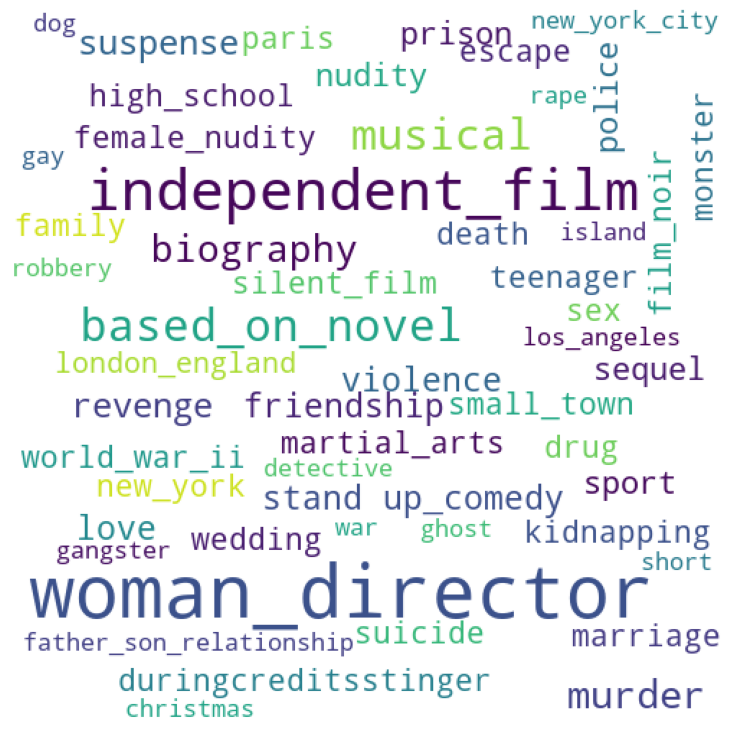

14:46: W605 invalid escape sequence '\s'
14:46: W605 invalid escape sequence '\s'


In [21]:
vectorizer = CountVectorizer(stop_words='english')
'''
Imports the 44,000 movie database into
a pandas df so you can retrieve the columns.
There are 24 columns in the database ranging
from keywords to director.
'''

df = prep_db(MAIN_FOLDER + MWML_FOLDER + CLEANED_FILE, 'csv')
df = df[['title', 'keywords']]

#  df = df.head(38000)
df['keywords'] = df['keywords'].str.replace(', ', ',')
df['keywords'] = df['keywords'].str.replace("\s", '_')
print('The selection types are : ')
print(df.info())

print(f'RAM = {psutil.virtual_memory().percent}')

# Main functions
# counts all theindividual words in the title and the keywords
counts = highest_count_words(df)

# organizes the word count
frequent_words, movie_counts = most_frequent_words(counts)
print(display(frequent_words.head(10)))
movies = make_pandas(freq_words=frequent_words.head(50),
                     nr_of_movies=20, movie_counts=movie_counts)
movies.to_csv(MAIN_FOLDER + MWML_FOLDER +
              'word_cloud_movie_recommendations.csv',
              index=False, header=True, sep=';')
'''
A word cloud is generated here based on the occurance of keyword words
'''
word_cloud(df['keywords'])